# Evaluation

**TCHUENKAM DJILO - Lauris**

## Problématique 

Prédire la classe d'une voiture sachant que : 
- Classe 1 : MPG < 18
- Classe 2 : 18 <= MPG < 24
- Classe 3 : 24 <= MPG < 30
- Classe 4 : MPG >= 30

Justifiez vos choix.

## Etape n°1 - Exploration des données

Visualisez les données pour en tirer des conclusions. Commentez les résultats. 

Exemples : nombres de valeurs manquantes, représentation des classes, types de données, ...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
base_dataset = pd.read_csv("car_performance.csv")
base_dataset.head()

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
0,volvo 245,European,76,20.0,4,130.0,102.0,3150,15.7
1,amc matador,American,76,15.5,8,304.0,120.0,3962,13.9
2,amc hornet sportabout (sw),American,71,18.0,6,258.0,110.0,2962,13.5
3,amc hornet,American,73,18.0,6,232.0,100.0,2945,16.0
4,vw dasher (diesel),European,80,43.4,4,90.0,48.0,2335,23.7


In [3]:
## Calcul du nombre d'observations dans le jeu de données
len(base_dataset)

406

In [4]:
## Nombre d'observations ayant des valeurs manquantes
base_dataset.shape[0] - base_dataset.dropna().shape[0]

14

In [5]:
## Description des variables à priori numériques
base_dataset.drop(['name', 'origin'], axis=1).describe()

,year,mpg,cylinders,engine,horsepower,weight,acceleration
count,406.000000,398.000000,406.000000,406.000000,400.000000,406.000000,406.000000
mean,75.921182,23.514573,5.475369,194.779557,105.082500,2979.413793,15.519704
std,3.748737,7.815984,1.712160,104.922458,38.768779,847.004328,2.803359
min,70.000000,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000
25%,73.000000,17.500000,4.000000,105.000000,75.750000,2226.500000,13.700000
50%,76.000000,23.000000,4.000000,151.000000,95.000000,2822.500000,15.500000
75%,79.000000,29.000000,8.000000,302.000000,130.000000,3618.250000,17.175000
max,82.000000,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000


In [6]:
## Description des variables qualitatives
base_dataset[['name', 'origin']].describe()

,name,origin
count,406,406
unique,312,3
top,ford pinto,American
freq,6,254


In [7]:
## Valeurs uniques de la variable cylinders
np.sort(base_dataset.cylinders.unique())

array([3, 4, 5, 6, 8])

### 1.1 Etude des données manquantes
Au vu de la description des variables, nous obsvervons qu'il existe des données manquantes. Notamment sur les variables **mpg** et **horsepower**, respectivement avec 8 et 6 valeurs manquantes pour un total de 14 observations affectées. Cet éffectif étant très faible par rapport à l'éffectif total, **l'on pourra se passer des observations concernées par la suite**.

### 1.2. Type des variables
| Variable | Type | Justificatif |
| :- | :- | :- |
| **name** | **Qualitatif nominal** | Il s'agit d'une variable qualitative n'ayant pas un nombre de modalité fixe |
| **origin** | **Qualitatif nominal à k modalités** | De par sa définition et en observant la description |
| **year** | **Numérique** | Choix le mieux adapté |
| **mpg** | **Numérique** | De par sa définition |
| **cylinders** | **Qualitatif ordinal à k modalités** | Variable représentant le nombre de cylindre du moteur. Bien qu'étant un entier naturel, il ne peut y avoir qu'un nombre limité de cylindre dans un moteur. De plus, il existe un ordre entre les valeurs possibles |
| **engine** | **Numérique** | De par sa définition |
| **horsepower** | **Numérique** | De par sa définition |
| **weight** | **Numérique** | De par sa définition |
| **acceleration** | **Numérique** | De par sa définition |

## Etape n°2 - Nettoyage et préparation des données

Justifiez vos choix.

### 2.1. Nettoyage des données

#### 2.1.1. Suppréssion des lignes ayant des valeurs manquantes

In [8]:
proper_data = base_dataset.dropna()
proper_data.describe(include='all')

,name,origin,year,mpg,cylinders,engine,horsepower,weight,acceleration
count,392,392,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
unique,301,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,amc matador,American,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,5,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,75.979592,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327
std,NaN,NaN,3.683737,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864
min,NaN,NaN,70.000000,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000
25%,NaN,NaN,73.000000,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000
50%,NaN,NaN,76.000000,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000
75%,NaN,NaN,79.000000,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000


#### 2.1.2. Codage de la variable **mpg** pour avoir la classe

In [9]:
def encode_mpg(x):
    if x[3]<18:
        x[-1]='Class 1'
    elif x[3]>=18 and x[3]<24:
        x[-1]='Class 2'
    elif x[3]>=24 and x[3]<30:
        x[-1]='Class 3'
    else:
        x[-1]='Class 4'
    return x

In [10]:
proper_data = proper_data.assign(car_class=None)
proper_data = proper_data.apply(encode_mpg, axis=1).drop(['mpg'], axis=1)

#### 2.1.3.  Transformation de la variable **name** en **brand**
La variable **name** est une variable trop spécifique à chaque observation. Toute fois, l'on remarque que le premier mot de chaque nom fait reférence à une marque de voiture. Cette variable par contre pourrait être plus intéressante.

In [11]:
def encode_brand(x):
    x[-1] = x[0].split(' ')[0]
    return x

In [12]:
proper_data = proper_data.assign(brand=None)
proper_data = proper_data.apply(encode_brand, axis=1).drop(['name'], axis=1)
proper_data

,origin,year,cylinders,engine,horsepower,weight,acceleration,car_class,brand
0,European,76,4,130.0,102.0,3150,15.7,Class 2,volvo
1,American,76,8,304.0,120.0,3962,13.9,Class 1,amc
2,American,71,6,258.0,110.0,2962,13.5,Class 2,amc
3,American,73,6,232.0,100.0,2945,16.0,Class 2,amc
4,European,80,4,90.0,48.0,2335,23.7,Class 4,vw
...,...,...,...,...,...,...,...,...,...
401,Japanese,74,4,108.0,93.0,2391,15.5,Class 3,subaru
402,Japanese,72,4,97.0,88.0,2100,16.5,Class 3,toyota
403,American,81,8,350.0,105.0,3725,19.0,Class 3,oldsmobile
404,American,78,4,156.0,105.0,2745,16.7,Class 2,plymouth


### 2.2. Visualisation des distributions

#### 2.2.1. Visualisation des distributions des classes

[Text(0, 0.5, 'Effectif')]

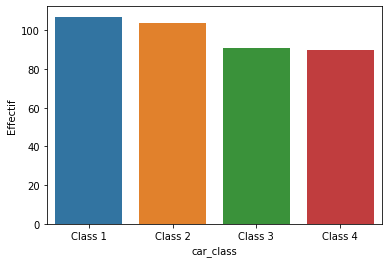

In [13]:
ax = sns.countplot(data=proper_data, x='car_class', order=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
ax.set(ylabel = 'Effectif')

**Interprétation** : L'on observe que les classes sont plutot équilibrées. Nous n'avons donc pas de problème de sous-représentation.<br>

#### 2.2.2. Distribution des variables numériques

<AxesSubplot:>

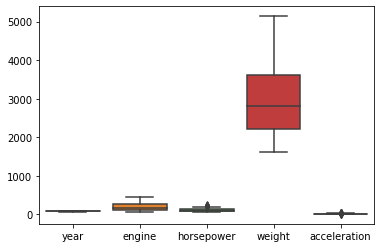

In [14]:
sns.boxplot(data=proper_data.drop(['brand', 'car_class', 'origin', 'cylinders'], axis=1))

**Interprétation** : L'on remarque que les valeurs de la classe **weight** sont très grandes par rapport à celles des autres. Il faudra donc probablement normaliser nos variables, cela dépendra du modèle que nous utiliserons.
#### 2.2.3. Distribution par paires de variables numériques

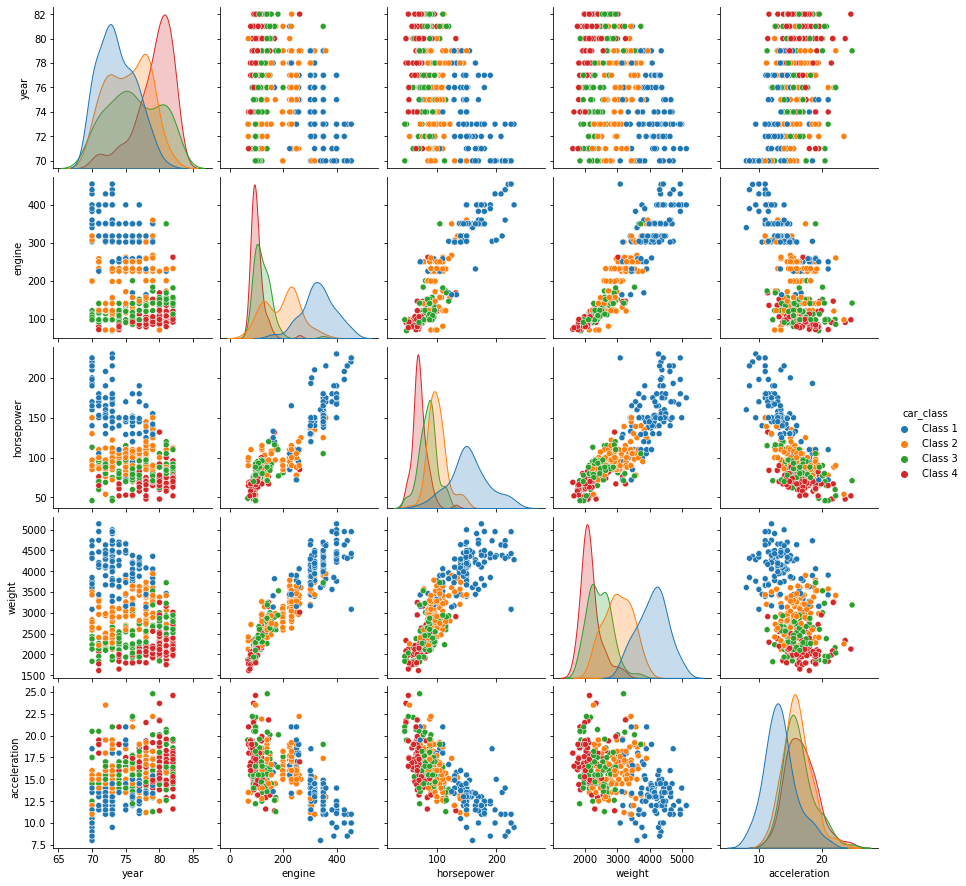

In [15]:
sns.pairplot(proper_data.drop(['brand', 'origin', 'cylinders'], axis=1), hue='car_class', hue_order=['Class 1', 'Class 2', 'Class 3', 'Class 4'])

**Interprétation** : Il semblerait qu'il existe un corrélation linéaire entre les couples de variables (**weight**, **engine**), (**weight**, **horsepower**), (**horsepower**, **engine**) et peut être aussi (**acceleration**, **horsepower**). L'analyse des corrélations qui va suivre nous permettra de conclure.

### 2.3. Analyse des corrélations

In [16]:
def plot_corr_matrix(corr_matrix_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    heatmap = sns.heatmap(np.array(corr_matrix_df.values, dtype=float), annot=True, xticklabels=corr_matrix_df.columns, yticklabels=corr_matrix_df.columns)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Pour la corrélation entre variables qualitatives, nous utilisons le [coéfficient de corrélation de Cramer V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V).

In [19]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    obs = confusion_matrix.sum().sum()
    mini = min(confusion_matrix.shape)-1
    return np.sqrt(chi2/(obs*mini))

#### 2.3.1 Entre variables numériques

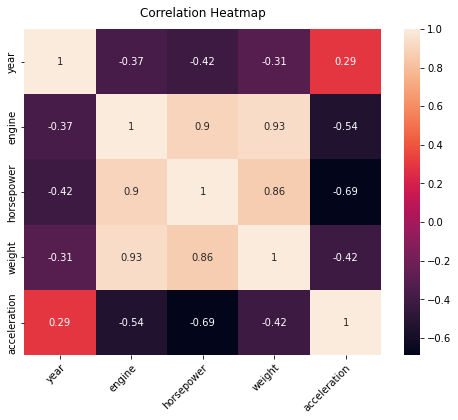

In [20]:
pearson_correlations = proper_data.drop(['brand', 'origin', 'cylinders', 'car_class'], axis=1).corr(method = 'pearson')
plot_corr_matrix(pearson_correlations)

**Interprétation** : L'on observe éffectivement une forte corrélation entre les couples de variables (**weight**, **engine**), (**weight**, **horsepower**) et (**horsepower**, **engine**). Il serait peut-être intéressant de se débarasser de 2 de trois variables concernées lors de la construction de notre modèle prédictif. <br>
#### 2.3.2. Entre variables qualitatives

In [21]:
def corr_matrix(df):
    corr = pd.DataFrame(index=df.columns, columns=df.columns)
    for i, var1 in enumerate(df.columns):
        for j in np.arange(i, len(df.columns)):
            var2 = df.columns[j]
            if i==j:
                corr[var1][var2] = 1.0
            else:
                corr[var1][var2] = corr[var2][var1] = round(cramers_v(df[var1], df[var2]), 2)
    return corr

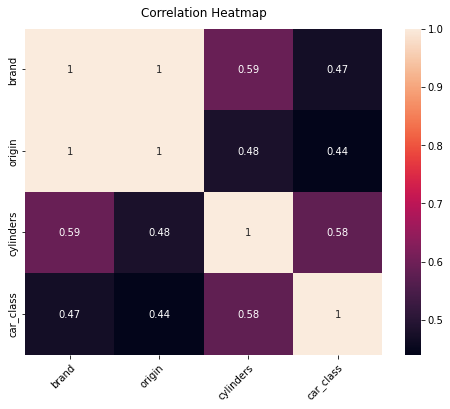

In [22]:
plot_corr_matrix(corr_matrix(proper_data[['brand', 'origin', 'cylinders', 'car_class']]))

**Interprétation** : L'on remarque une corrélation parfaite entre les variables **origin** et **brand**. Toute fois, la corrélation entre **brand** et le target **car_class** est plus forte que celle entre **origin** et **car_class**. L'on pourrait donc penser à conserver la variable **brand** plutot que la variable **origin**.

### 2.4. Choix final des variables
Pour la construction de notre modèle prédictif, nous allons nous débarasser des variables **weight**, **horsepower** et **origin**.

In [23]:
proper_data.drop(['weight', 'horsepower', 'origin'], axis=1, inplace=True)
proper_data

,year,cylinders,engine,acceleration,car_class,brand
0,76,4,130.0,15.7,Class 2,volvo
1,76,8,304.0,13.9,Class 1,amc
2,71,6,258.0,13.5,Class 2,amc
3,73,6,232.0,16.0,Class 2,amc
4,80,4,90.0,23.7,Class 4,vw
...,...,...,...,...,...,...
401,74,4,108.0,15.5,Class 3,subaru
402,72,4,97.0,16.5,Class 3,toyota
403,81,8,350.0,19.0,Class 3,oldsmobile
404,78,4,156.0,16.7,Class 2,plymouth


## Etape n°3 - Choix et construction du modèle

Vous pouvez tester plusieurs modèles mais il faut dans tous les cas justifier en quoi cette architecture/modèle est pertinente par rapport à la problématique. 

Pour notre modèle, nous allons utiliser la méthode **Random Forest**. Notre choix se base sur les raisons suivantes:
- Nous remarquons que pour la plus part des distributions des paires de variables au 2.2.3., les classes différentes semblent être disposées en strates superposées. Il semble donc possible de les séparer à l'aide de rectangles (hyperrectangles), ce qui nous ramène aux abres de décisions
- Pour s'assurer que nous n'ayons pas de problème d'hyperspécialisation, et aussi améliorer nos performances, il serait intéressant d'entrainer plusieurs abres de décision et de les faire voter la classe des observations.
<br>

Etant donné que les arbres de décision ne se basent pas sur les distances entre individus, il n'est pas necessaire de normaliser nos variables numériques.<br>
En ce qui concerne les variables qualitatives, nous y appliquont un codage disjonctif binaire.

In [26]:
columns_transformer = ColumnTransformer([
   ('cylinders_one_hot_encoder', OneHotEncoder(), ['cylinders'])
   , ('brand_one_hot_encoder', OneHotEncoder(), ['brand'])
], remainder='passthrough')
N_SPLITS = 5
params_grid = {
    'n_estimators': np.arange(10, 21)
    , 'criterion': ['gini', 'entropy']
    , 'max_samples': [0.8, 0.75, 0.7]
}
grid_searcher = GridSearchCV(
    RandomForestClassifier()
    , param_grid=params_grid
    , scoring='f1_macro'
    , cv=StratifiedKFold(n_splits=N_SPLITS)
    , verbose=1
    , refit=True
    , n_jobs = 4
)
rf_pipeline = Pipeline([
    ('columns_transformer', columns_transformer),
    ('grid_searcher', grid_searcher)
])

## Etape n°4 - Evaluation et validation

Optimisez votre(vos) modèle(s) et donnez des résultats chiffrés/visuels de la pertinence de votre solution. Commentez les résultats. 

In [27]:
%%time
rf_pipeline.fit(proper_data.drop(['car_class'], axis=1), proper_data['car_class'])
grid_searcher = rf_pipeline.named_steps['grid_searcher']
best_estimator = grid_searcher.best_estimator_
best_estimator_hyper_params = grid_searcher.best_params_
best_estimator_score = grid_searcher.best_score_
best_estimator_std = grid_searcher.cv_results_['std_test_score'][grid_searcher.cv_results_['rank_test_score'][0]]

Fitting 5 folds for each of 66 candidates, totalling 330 fits
CPU times: user 441 ms, sys: 14.8 ms, total: 455 ms
Wall time: 5.32 s


In [28]:
print("Best estimator : {}\nBest hyperparams : {}\nBest estimator score : {}\nBest estimator std : {}".format(best_estimator, best_estimator_hyper_params, best_estimator_score, best_estimator_std))

Best estimator : RandomForestClassifier(criterion='entropy', max_samples=0.8, n_estimators=13)
Best hyperparams : {'criterion': 'entropy', 'max_samples': 0.8, 'n_estimators': 13}
Best estimator score : 0.7792762865388427
Best estimator std : 0.020983584124277088


<br>Nous avons utilisé un protocole de validation K-fold avec **5 splits**. Sur l'ensemble des hyperparamètres définis pour la recherche des hyperparamètres optimaux, le meilleur estimateur présente un score **F1** de **78.54%** et un écart type de **0.044**.<br>
Bien que notre modèle ne présente pas une performance extraordinaire, il a un variance plutot faible, qui fait de lui un modèle stable.